In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics.cluster import adjusted_mutual_info_score


In [ ]:
  import os                           
import math                         
import numpy as np                  
from scipy import signal, stats     
from scipy.fft import fftshift      
import matplotlib.pyplot as plt     
import statistics                   
import time                         
import pickle                                 
import json                         
import datetime 
import warnings
warnings.filterwarnings('ignore')
import librosa
import soundfile as sf
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as pyo
import seaborn as sns # Seaborn (version : 0.11.1)
plt.style.use('seaborn')
indices_escogidos=['BETA','P','M','NP','BNF','MD','SF','RMS','CF','SC','SNR']
from sklearn import metrics
from numpy import linalg as LA
from scipy.spatial import distance

In [ ]:
from sklearn.cluster import kmeans_plusplus
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from copy import deepcopy
from matplotlib.pyplot import figure




In [ ]:
def uncertainity_mean(X_train1,pred,means,covariances,weights,km,numberofdimens):
  X_train1["pred"]=pred
  meanss=means
  weiths=weights
  variances=[]
  covariancematrix=covariances
  for i in covariancematrix: #The diagonal of cov is the variance of each gmm
    diag=np.diag(i)
    variances.append(diag)
  variances=np.array(variances)
  countiterations=0
  unc=[]
  un=[]

  sep=[]
  for g in range(0,len(meanss)):  ##Frechet distance
    for t in range(0,len(meanss)):
      if (t==g):
        continue
      else:  
        sep.append(frechetDistance(meanss[t],meanss[g],covariancematrix[t],covariancematrix[g]))
  separation=np.array(sep)
  Dmin=np.array(separation).min()
  Dmax=np.array(separation).max()
  Sep=(Dmax/Dmin)*(1/separation.sum())

  for i in range(0,len(meanss)):  #Uncertainty  ##i run each cluster
    cweight=weiths[i]
    cmean=meanss[i]
    cvar=variances[i]
    lim_inf=cmean-(km*cvar)
    lim_sup=cmean+(km*cvar)
    unc=[]
    o=X_train1[X_train1["pred"]==i].iloc[:,:numberofdimens].copy()

    for j in range(len(o)): # j run each data 
      DM=distance.mahalanobis(np.array(o.iloc[j]), cmean, np.linalg.inv(covariancematrix[i]))
      varbool=(DM>=km)
      varunc=[]
      #print("varbool",varbool)
      if (varbool):
        varunc.append(2*km*DM)
      else:
        vs=((DM**2)+(km*DM)+(km**2)/2)
        varunc.append(vs)
    un.append(np.array(varunc)) 
  return np.sum(un)/Sep

In [ ]:

def merguncertain (xtrain,y,Means,covariances,weights,numberofdimens):
  X_train11=xtrain
  X_train11["pred"]=y
  UNIndex=[]
  len(Means)
  Pairwise=np.ones((len(Means), len(Means)))
  labels=[]
  for i in range(len(Means)):
    labels.append(i)
    for j in range(len(Means)):
        if (i==j):
          continue
        Pairwise[j,i]=(frechetDistance(Means[i],Means[j],covariances[i],covariances[j]))
        
  while len(Pairwise) > 2 :
      UNIndex.append(uncertainity_mean(X_train11.iloc[:,:numberofdimens],X_train11["pred"],Means,covariances,weights,1,numberofdimens))

      Similar_clusters=np.unravel_index(Pairwise.argmin(),Pairwise.shape)  
      Similar_clusters_labels=( labels[Similar_clusters[0]],labels[Similar_clusters[1]])

      #update Mean
      data_size_1=len(X_train11[X_train11["pred"]==Similar_clusters_labels[0]])
      data_size_2=len(X_train11[X_train11["pred"]==Similar_clusters_labels[1]])
      mean_1=Means[Similar_clusters[0]]
      mean_2=Means[Similar_clusters[1]] 
      new_mean = (data_size_1* mean_1 + data_size_2*mean_2)/(data_size_1 + data_size_2)
      Means[Similar_clusters[0]]=new_mean

      #Update labels
      X_train11["pred"]=X_train11["pred"].replace(Similar_clusters_labels[1], Similar_clusters_labels[0])
      #print(X_train11["pred"].unique())
      NewCovariance=X_train11[X_train11["pred"]==Similar_clusters_labels[0]].iloc[:,:numberofdimens].cov()
      covariances[Similar_clusters[0]]=NewCovariance
      weights[Similar_clusters[0]]=weights[Similar_clusters[0]]+weights[Similar_clusters[1]]

      updpairwisecolum=[]
      for j in range(0,len(Means)):
          updpairwisecolum.append((frechetDistance(Means[Similar_clusters[0]],Means[j],covariances[Similar_clusters[0]],covariances[j])))
      #print(updpairwisecolum)    
      Pairwise[:,Similar_clusters[0]]=updpairwisecolum
      Pairwise[Similar_clusters[0],:]=updpairwisecolum

      Means= np.delete(Means, (Similar_clusters[1]), axis=0)
      weights= np.delete(weights, (Similar_clusters[1]), axis=0)
      covariances=np.delete(covariances, (Similar_clusters[1]), axis=0)
      labels.remove(Similar_clusters_labels[1])
      Pairwise= np.delete(Pairwise, (Similar_clusters[1]), axis=0)
      Pairwise= np.delete(Pairwise, (Similar_clusters[1]), axis=1)
      np.fill_diagonal(Pairwise, 1)
  return UNIndex

In [ ]:
def frechetDistance(u1,u2,E1,E2): 
  return (LA.norm(np.absolute(u1-u2)**2))+np.trace(E1+E2-(2*(E1*E2)**(0.5)))

In [ ]:
def genData(n_samples,n_featuress, n_components,cl_std,randomstate):
  X, y_true = make_blobs(
        n_samples, n_features, centers=n_components, cluster_std=cl_std, random_state=randomstate
    )
  X = X[:, ::-1]
  dataFrame=pd.DataFrame(X)
  dataFrame["y"]=y_true
  return dataFrame

# mdcgenpy framework

In [ ]:
!git clone https://github.com/CN-TU/mdcgenpy

Cloning into 'mdcgenpy'...
remote: Enumerating objects: 202, done.
remote: Total 202 (delta 0), reused 0 (delta 0), pack-reused 202
Receiving objects: 100% (202/202), 56.64 KiB | 479.00 KiB/s, done.
Resolving deltas: 100% (105/105), done.


In [ ]:
cd mdcgenpy

/content/mdcgenpy


In [ ]:
ls

docs/              LICENSE    mdcgenpy.py*  requirements.txt
json_example.json  mdcgenpy/  README.rst    setup.py


In [ ]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
ls

docs/              LICENSE    mdcgenpy.py*  requirements.txt
json_example.json  mdcgenpy/  README.rst    setup.py


In [ ]:
cd mdcgenpy/ 

/content/mdcgenpy/mdcgenpy


In [ ]:
from clusters import ClusterGenerator

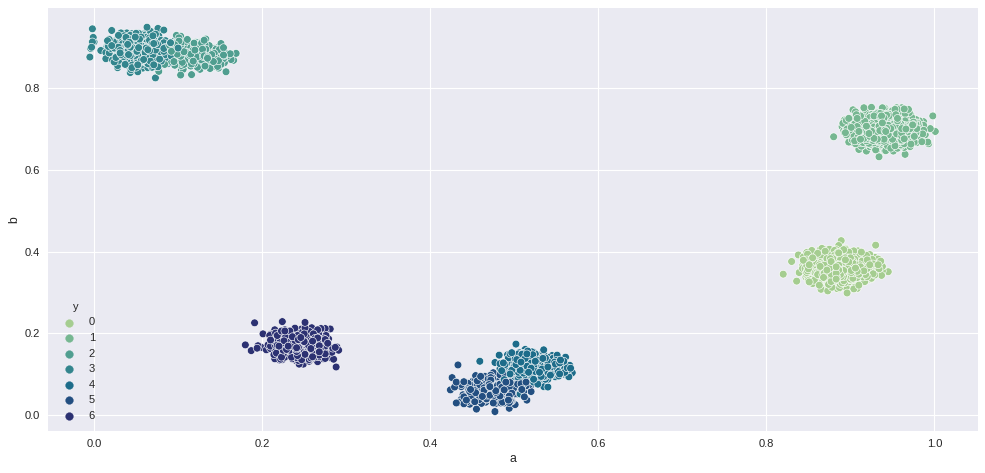

In [ ]:
from clusters import ClusterGenerator
import pandas as pd

cluster_gen=ClusterGenerator(seed=1, n_samples=5000, n_feats=2, k=7, min_samples=0,
                  distributions='normal', mv=False, corr=0., compactness_factor=0.3, alpha_n=4,
                  scale=True, outliers=0, rotate=False, add_noise=0, n_noise=None, ki_coeff=3.)
data = cluster_gen.generate_data()
dataFrame= pd.DataFrame(data[0],columns=["a","b"]).round(3)
dataFrame['y']=data[1]
figure(figsize=(15, 7), dpi=80)
sns.scatterplot(data=dataFrame, x='a', y='b', hue='y',palette="crest");

#Iris Dataset


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

# save load_iris() sklearn dataset to iris
# if you'd like to check dataset type use: type(load_iris())
# if you'd like to view list of attributes use: dir(load_iris())
iris = load_iris()

# np.c_ is the numpy concatenate function
# which is used to concat iris['data'] and iris['target'] arrays 
# for pandas column argument: concat iris['feature_names'] list
# and string list (in this case one string); you can make this anything you'd like..  
# the original dataset would probably call this ['Species']
data1 = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

In [ ]:
data1

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


## Only with the index 


In [ ]:
Index=[]
liminfierior=2
limsuperior=20
for i in range(2,20):
  Y = data1["target"]
  X = data1.drop(columns = "target")

  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)$

  X_train111=X.copy()
  GM = GaussianMixture(n_components=i, covariance_type="full",random_state=1).fit(X_train111)
  X_train111["pred"]=GM.predict(X_train111)
  Means=GM.means_
  covariances=GM.covariances_
  weights=GM.weights_
  numberofdimens=X_train111.shape[1]-1
  y=X_train111["pred"]
  Index.append(uncertainity_mean(X_train111.iloc[:,:numberofdimens],X_train111["pred"],Means,covariances,weights,1,numberofdimens))
  

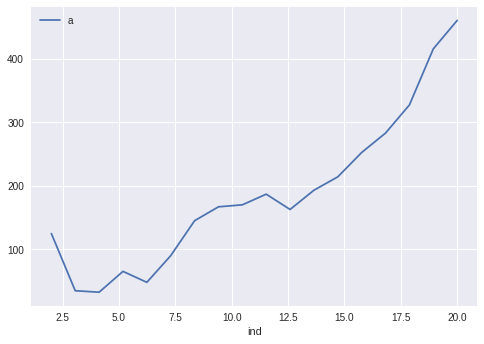

In [ ]:
change=pd.DataFrame(Index,columns=["a"])
change["ind"]=np.linspace(2,len(change)+2,len(change))

change.plot("ind",["a"])

In [ ]:
change["a"].argmin()

2

## Merging uncertainity

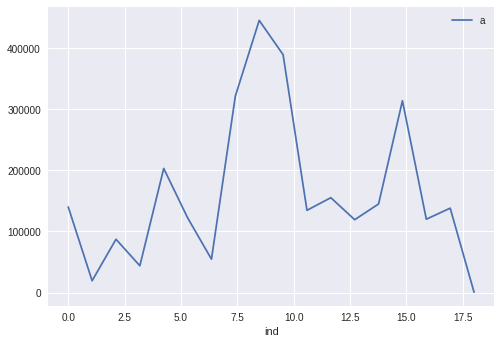

In [ ]:
from sklearn.model_selection import train_test_split

Y = data1["target"]
X = data1.drop(columns = "target")

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)$

X_train111=X.copy()
GM = GaussianMixture(n_components=20, covariance_type="full").fit(X_train111)
X_train111["pred"]=GM.predict(X_train111)
Means=GM.means_
covariances=GM.covariances_
weights=GM.weights_
y=X_train111["pred"]
index=merguncertain (X,y,Means,covariances,weights,X.shape[1])
index.reverse()
change=pd.DataFrame(index,columns=["a"])
change["ind"]=np.linspace(0,len(change),len(change))

change.plot("ind",["a"])


In [ ]:
change

,a,ind
0,140129.544294,0.000000
1,19318.203168,1.058824
2,87222.544494,2.117647
3,43859.163466,3.176471
4,203138.658462,4.235294
5,122386.136017,5.294118
6,54660.844646,6.352941
7,321545.183515,7.411765
8,445456.190564,8.470588
9,389394.330088,9.529412


In [ ]:
change=change.iloc[:-1,:]

In [ ]:
recomended=change["a"].argmin()
recomended

1

In [ ]:
recomended=change["a"].argmin()+2
GMM_test= GaussianMixture(n_components=recomended, covariance_type="full",random_state=0).fit(X)
predy=GMM_test.predict(X)
recomended

3

In [ ]:
change

,a,ind
0,140129.544294,0.000000
1,19318.203168,1.058824
2,87222.544494,2.117647
3,43859.163466,3.176471
4,203138.658462,4.235294
5,122386.136017,5.294118
6,54660.844646,6.352941
7,321545.183515,7.411765
8,445456.190564,8.470588
9,389394.330088,9.529412


In [ ]:
adjusted_mutual_info_score(Y, predy)

0.7155660748905579

In [ ]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(Y, predy)

0.5793801642856945

#wine Dataset


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine

# save load_iris() sklearn dataset to iris
# if you'd like to check dataset type use: type(load_iris())
# if you'd like to view list of attributes use: dir(load_iris())
iris = load_wine()

# np.c_ is the numpy concatenate function
# which is used to concat iris['data'] and iris['target'] arrays 
# for pandas column argument: concat iris['feature_names'] list
# and string list (in this case one string); you can make this anything you'd like..  
# the original dataset would probably call this ['Species']
data1 = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

In [ ]:
data1

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2.0


In [ ]:
data1['target'].unique()

array([0., 1., 2.])

In [ ]:
def uncertainity_mean(X_train1,pred,means,covariances,weights,km,numberofdimens):
  X_train1["pred"]=pred
  meanss=means
  weiths=weights
  variances=[]
  covariancematrix=covariances
  for i in covariancematrix: #The diagonal of cov is the variance of each gmm
    diag=np.diag(i)
    variances.append(diag)
  variances=np.array(variances)
  countiterations=0
  unc=[]
  un=[]

  sep=[]
  for g in range(0,len(meanss)):  ##Frechet distance
    for t in range(0,len(meanss)):
      if (t==g):
        continue
      else:  
        sep.append(frechetDistance(meanss[t],meanss[g],covariancematrix[t],covariancematrix[g]))
  separation=np.array(sep)
  Dmin=np.array(separation).min()
  Dmax=np.array(separation).max()
  Sep=(Dmax/Dmin)*(1/separation.sum())

  for i in range(0,len(meanss)):  #Uncertainty  ##i run each cluster
    cweight=weiths[i]
    cmean=meanss[i]
    cvar=variances[i]
    lim_inf=cmean-(km*cvar)
    lim_sup=cmean+(km*cvar)
    unc=[]
    o=X_train1[X_train1["pred"]==i].iloc[:,:numberofdimens].copy()
    

    for j in range(len(o)): # j run each data 

      varbool=(distance.mahalanobis(np.array(o.iloc[j]), cmean, np.linalg.inv(covariancematrix[i]))>=km)
      varunc=[]
      #print("varbool",varbool)
      if(varbool):
        varunc.append(2*km*distance.mahalanobis(np.array(o.iloc[j]), cmean, np.linalg.inv(covariancematrix[i])))
      else:
        vs=((distance.mahalanobis(np.array(o.iloc[j]), cmean, np.linalg.inv(covariancematrix[i]))**2)+(km*distance.mahalanobis(np.array(o.iloc[j]), cmean, np.linalg.inv(covariancematrix[i])))+(km**2)/2)
        varunc.append(vs)
    un.append(np.array(varunc)) 
  return np.sum(un)/Sep

## Only with the index 


In [ ]:
Index=[]
liminfierior=2
limsuperior=20
for i in range(2,20):
  Y = data1["target"]
  X = data1.drop(columns = "target")

  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)$

  X_train111=X.copy()
  GM = GaussianMixture(n_components=i, covariance_type="full",random_state=1).fit(X_train111)
  X_train111["pred"]=GM.predict(X_train111)
  Means=GM.means_
  covariances=GM.covariances_
  weights=GM.weights_
  numberofdimens=X_train111.shape[1]-1
  y=X_train111["pred"]
  Index.append(uncertainity_mean(X_train111.iloc[:,:numberofdimens],X_train111["pred"],Means,covariances,weights,1,numberofdimens))
  

In [ ]:
numberofdimens

13

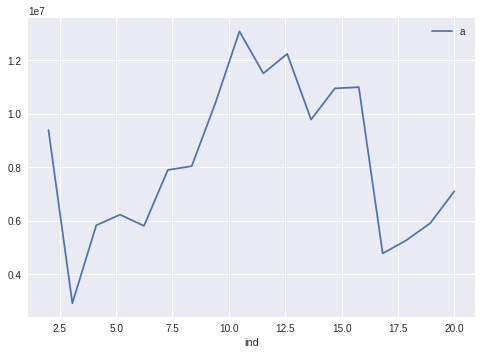

In [ ]:
change=pd.DataFrame(Index,columns=["a"])
change["ind"]=np.linspace(2,len(change)+2,len(change))

change.plot("ind",["a"])

In [ ]:
change["a"].argmin()+2

3

## With the merging methodology 

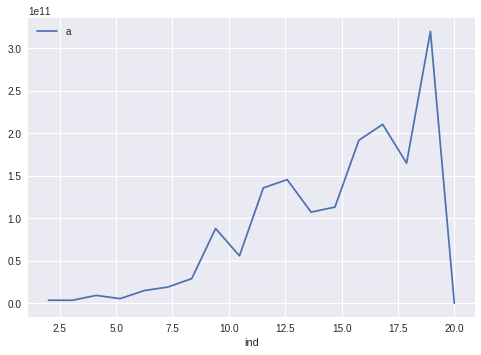

In [ ]:
from sklearn.model_selection import train_test_split

Y = data1["target"]
X = data1.drop(columns = "target")

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)$

X_train111=X.copy()
GM = GaussianMixture(n_components=20, covariance_type="full").fit(X_train111)
X_train111["pred"]=GM.predict(X_train111)
Means=GM.means_
covariances=GM.covariances_
weights=GM.weights_
y=X_train111["pred"]
index=merguncertain (X,y,Means,covariances,weights,X.shape[1])
index.reverse()
change=pd.DataFrame(index,columns=["a"])
change["ind"]=np.linspace(2,len(change)+2,len(change))
change.plot("ind",["a"])


In [ ]:
recomended=change.iloc[:-1]["a"].argmin()+2
GMM_test= GaussianMixture(n_components=recomended, covariance_type="full",random_state=0).fit(X)
predy=GMM_test.predict(X)
recomended

3

In [ ]:
change["a"]

0     3.500144e+09
1     3.465519e+09
2     9.203356e+09
3     5.378805e+09
4     1.481000e+10
5     1.903995e+10
6     2.894699e+10
7     8.791268e+10
8     5.580085e+10
9     1.357537e+11
10    1.455013e+11
11    1.072438e+11
12    1.131670e+11
13    1.917524e+11
14    2.105717e+11
15    1.649089e+11
16    3.199651e+11
17    8.764822e+06
Name: a, dtype: float64

In [ ]:
change

,a,ind
0,3.500144e+09,2.000000
1,3.465519e+09,3.058824
2,9.203356e+09,4.117647
3,5.378805e+09,5.176471
4,1.481000e+10,6.235294
5,1.903995e+10,7.294118
6,2.894699e+10,8.352941
7,8.791268e+10,9.411765
8,5.580085e+10,10.470588
9,1.357537e+11,11.529412


In [ ]:
adjusted_mutual_info_score(Y, predy)

0.46661049042503355

In [ ]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(Y, predy)

0.4733896897497538

#digits Dataset


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits

# save load_iris() sklearn dataset to iris
# if you'd like to check dataset type use: type(load_iris())
# if you'd like to view list of attributes use: dir(load_iris())
iris = load_digits()

# np.c_ is the numpy concatenate function
# which is used to concat iris['data'] and iris['target'] arrays 
# for pandas column argument: concat iris['feature_names'] list
# and string list (in this case one string); you can make this anything you'd like..  
# the original dataset would probably call this ['Species']
data1 = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

In [ ]:
data1

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0,9.0
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,0.0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0,8.0
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0,9.0


In [ ]:
X = StandardScaler().fit_transform(data1)
data1 = pd.DataFrame(X, columns= data1.columns)

In [ ]:
data1['target'].unique()

array([-1.56774584, -1.21864556, -0.86954528, -0.52044499, -0.17134471,
        0.17775557,  0.52685585,  0.87595613,  1.22505642,  1.5741567 ])

## Only with the index 


In [ ]:
Index=[]
liminfierior=2
limsuperior=20
for i in range(2,30):
  Y = data1["target"]
  X = data1.drop(columns = "target")

  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)$

  X_train111=X.copy()
  GM = GaussianMixture(n_components=i, covariance_type="full",random_state=1).fit(X_train111)
  X_train111["pred"]=GM.predict(X_train111)
  Means=GM.means_
  covariances=GM.covariances_
  weights=GM.weights_
  numberofdimens=X_train111.shape[1]-1
  y=X_train111["pred"]
  Index.append(uncertainity_mean(X_train111.iloc[:,:numberofdimens],X_train111["pred"],Means,covariances,weights,1,numberofdimens))
  

In [ ]:
numberofdimens

64

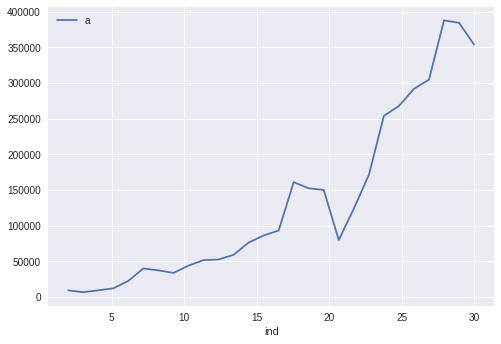

In [ ]:
change=pd.DataFrame(Index,columns=["a"])
change["ind"]=np.linspace(2,len(change)+2,len(change))

change.plot("ind",["a"])

In [ ]:
change["a"].argmin()+2

3

In [ ]:
adjusted_mutual_info_score(Y, predy)

0.7379972925554998

## With the merging methodology 

In [ ]:
from sklearn.model_selection import train_test_split

Y = data1["target"]
X = data1.drop(columns = "target")

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)$

X_train111=X.copy()
GM = GaussianMixture(n_components=20, covariance_type="full",random_state=1).fit(X_train111)
X_train111["pred"]=GM.predict(X_train111)
Means=GM.means_
covariances=GM.covariances_
weights=GM.weights_
y=X_train111["pred"]
index=merguncertain (X,y,Means,covariances,weights,X.shape[1])
index.reverse()
change=pd.DataFrame(index,columns=["a"])
recomended=change["a"].argmin()+2
GMM_test= GaussianMixture(n_components=recomended, covariance_type="full",random_state=0).fit(X)
predy=GMM_test.predict(X)
recomended

19

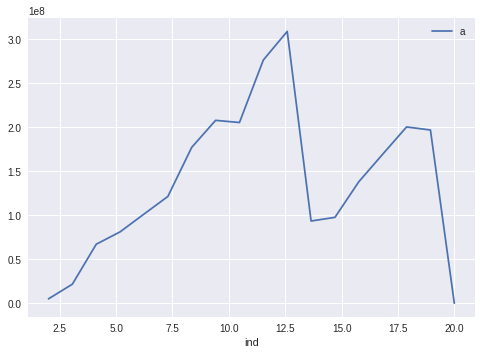

In [ ]:
change["ind"]=np.linspace(2,len(change)+2,len(change))

change.plot("ind",["a"])


In [ ]:
change

,a,ind
0,5.039818e+06,2.000000
1,2.172006e+07,3.058824
2,6.713497e+07,4.117647
3,8.121615e+07,5.176471
4,1.014192e+08,6.235294
5,1.214452e+08,7.294118
6,1.772988e+08,8.352941
7,2.079993e+08,9.411765
8,2.055601e+08,10.470588
9,2.766094e+08,11.529412


In [ ]:
adjusted_mutual_info_score(Y, predy)

0.7379972925554998

In [ ]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(Y, predy)

0.8105870790694133

#breast cancer Dataset


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer

# save load_iris() sklearn dataset to iris
# if you'd like to check dataset type use: type(load_iris())
# if you'd like to view list of attributes use: dir(load_iris())
iris = load_breast_cancer()

# np.c_ is the numpy concatenate function
# which is used to concat iris['data'] and iris['target'] arrays 
# for pandas column argument: concat iris['feature_names'] list
# and string list (in this case one string); you can make this anything you'd like..  
# the original dataset would probably call this ['Species']
data1 = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

UFuncTypeError: ignored

In [ ]:
data1 = pd.DataFrame(iris.data, columns= iris.feature_names)

In [ ]:
X = StandardScaler().fit_transform(data1)
data1 = pd.DataFrame(X, columns= iris.feature_names)

In [ ]:
data1['target']=iris['target']

In [ ]:
data1

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,0
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,0
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,0
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,0
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.110995,0.721473,2.060786,2.343856,1.041842,0.219060,1.947285,2.320965,-0.312589,-0.931027,...,0.117700,1.752563,2.015301,0.378365,-0.273318,0.664512,1.629151,-1.360158,-0.709091,0
565,1.704854,2.085134,1.615931,1.723842,0.102458,-0.017833,0.693043,1.263669,-0.217664,-1.058611,...,2.047399,1.421940,1.494959,-0.691230,-0.394820,0.236573,0.733827,-0.531855,-0.973978,0
566,0.702284,2.045574,0.672676,0.577953,-0.840484,-0.038680,0.046588,0.105777,-0.809117,-0.895587,...,1.374854,0.579001,0.427906,-0.809587,0.350735,0.326767,0.414069,-1.104549,-0.318409,0
567,1.838341,2.336457,1.982524,1.735218,1.525767,3.272144,3.296944,2.658866,2.137194,1.043695,...,2.237926,2.303601,1.653171,1.430427,3.904848,3.197605,2.289985,1.919083,2.219635,0


In [ ]:
data1.columns

Index(['worst concave points', 'worst area', 'mean concave points',
       'worst radius', 'worst perimeter', 'target'],
      dtype='object')

In [ ]:
data1['target'].unique()

array([0, 1])

In [ ]:
data1=data1[['worst concave points','worst area','mean concave points','worst radius','worst perimeter','target']]

## Only with the index 


In [ ]:
Index=[]
liminfierior=2
limsuperior=20
for i in range(2,20):
  Y = data1["target"]
  X = data1.drop(columns = "target")

  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)$

  X_train111=X.copy()
  GM = GaussianMixture(n_components=i, covariance_type="full").fit(X_train111)
  X_train111["pred"]=GM.predict(X_train111)
  Means=GM.means_
  covariances=GM.covariances_
  weights=GM.weights_
  numberofdimens=X_train111.shape[1]-1
  y=X_train111["pred"]
  Index.append(uncertainity_mean(X_train111.iloc[:,:numberofdimens],X_train111["pred"],Means,covariances,weights,3,numberofdimens))
  

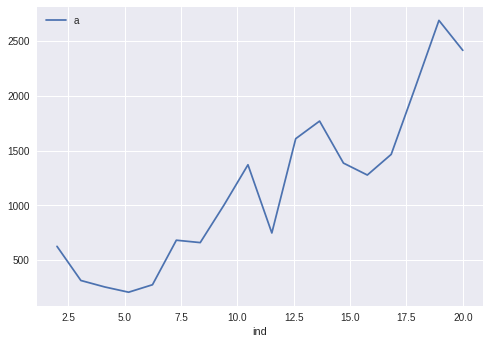

In [ ]:
change=pd.DataFrame(Index,columns=["a"])
change["ind"]=np.linspace(2,len(change)+2,len(change))
change.plot("ind",["a"])

In [ ]:
change["a"].argmin()

3

In [ ]:
recomended=change["a"].argmin()+2
GMM_test= GaussianMixture(n_components=recomended, covariance_type="full",random_state=0).fit(X)
predy=GMM_test.predict(X)
recomended

4

In [ ]:
adjusted_mutual_info_score(Y, predy)

0.4425510076351789

In [ ]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(Y, predy)

0.661960873098856

## With the merging methodology 

In [ ]:
from sklearn.model_selection import train_test_split

Y = data1["target"]
X = data1.drop(columns = "target")

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)$

X_train111=X.copy()
GM = GaussianMixture(n_components=20, covariance_type="full",random_state=1).fit(X_train111)
X_train111["pred"]=GM.predict(X_train111)
Means=GM.means_
covariances=GM.covariances_
weights=GM.weights_
y=X_train111["pred"]
index=merguncertain (X,y,Means,covariances,weights,X.shape[1])
index.reverse()
change=pd.DataFrame(index,columns=["a"])
change["ind"]=np.linspace(2,len(change)+2,len(change))

change.plot("ind",["a"])

In [ ]:
recomended=change.iloc[:-1]["a"].argmin()+2
GMM_test= GaussianMixture(n_components=recomended, covariance_type="full",random_state=0).fit(X)
predy=GMM_test.predict(X)
recomended

2

In [ ]:
change["a"]


0       1366.199273
1     409352.490974
2     327986.509168
3     332877.511422
4       1638.632708
5     771066.118714
6       2184.416196
7       2908.635507
8       3709.770640
9      18679.285326
10      4678.371400
11      5448.574208
12      5770.578253
13     27932.048745
14      5023.782663
15      7568.325544
16     11299.992734
17       558.567509
Name: a, dtype: float64

In [ ]:
adjusted_mutual_info_score(Y, predy)

0.0852397563513742

In [ ]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(Y, predy)

0.05685782166085721

# Liver dataset

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

# PCA
from sklearn.decomposition import PCA


# Carrega a função SMOTE
import imblearn
from imblearn.over_sampling import SMOTE

# Ensemble Classifiers
from sklearn.ensemble import VotingClassifier, BaggingClassifier

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.metrics import accuracy_score


from sklearn.pipeline import Pipeline

%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")
# Functions
def plot_sklearn_roc_curve(y_real, y_pred, auc, model_name):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
    plt.plot([0, 1], [0, 1], color = 'g',label="AUC="+str(round(auc,2)))
    plt.title('AUC: ' + model_name)
    plt.legend(loc=4, fontsize='xx-large')
    

    

In [ ]:
dados = pd.read_csv('/content/drive/MyDrive/Doctorado/2022/Diciembre/indian_liver_patient.csv')
dados.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [ ]:
dados['Dataset'].unique()

array([1, 2])

In [ ]:
dados_duplicados = dados[dados.duplicated(keep = False)]
dados = dados.dropna(how = 'any')
dados = dados.drop_duplicates()
dados['Gender'] = np.where(dados['Gender'] == 'Female', 0, 1)


In [ ]:
X = StandardScaler().fit_transform(dados)
dados = pd.DataFrame(X, columns= dados.columns)

In [ ]:
dados

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,1.236928,-1.761093,-0.420124,-0.495190,-0.429625,-0.352659,-0.315148,0.280819,0.194225,-0.150315,-0.633238
1,1.052432,0.567829,1.203777,1.406906,1.654054,-0.088755,-0.033926,0.925059,0.068445,-0.651328,-0.633238
2,1.052432,0.567829,0.630636,0.913770,0.803490,-0.110747,-0.143671,0.464887,0.194225,-0.181628,-0.633238
3,0.806437,0.567829,-0.372362,-0.389518,-0.449974,-0.363655,-0.308289,0.280819,0.320004,0.162818,-0.633238
4,1.667418,0.567829,0.089335,0.174066,-0.397068,-0.292181,-0.174537,0.740991,-0.937791,-1.715981,-0.633238
...,...,...,...,...,...,...,...,...,...,...,...
561,0.929434,0.567829,-0.451965,-0.495190,0.844187,-0.330667,-0.260276,-0.547491,-1.944027,-1.809921,1.579186
562,-0.300540,0.567829,-0.436044,-0.495190,-0.791827,-0.248197,-0.270564,-0.455456,0.068445,0.475951,-0.633238
563,0.437445,0.567829,-0.404203,-0.459966,-0.193583,-0.176723,-0.208833,-0.087319,0.068445,0.162818,-0.633238
564,-0.854028,0.567829,-0.324600,-0.354294,-0.441834,-0.281185,-0.267135,0.280819,0.320004,0.162818,-0.633238


In [ ]:
dados['target'] = np.where(dados['Dataset'] == 2, 0, 1)
data1=dados.copy()

## Only with the index 


In [ ]:
Index=[]
liminfierior=2
limsuperior=20
for i in range(2,20):
  Y = data1["target"]
  X = data1.drop(columns = "target")

  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)$

  X_train111=X.copy()
  GM = GaussianMixture(n_components=i, covariance_type="full").fit(X_train111)
  X_train111["pred"]=GM.predict(X_train111)
  Means=GM.means_
  covariances=GM.covariances_
  weights=GM.weights_
  numberofdimens=X_train111.shape[1]-1
  y=X_train111["pred"]
  Index.append(uncertainity_mean(X_train111.iloc[:,:numberofdimens],X_train111["pred"],Means,covariances,weights,3,numberofdimens))
  

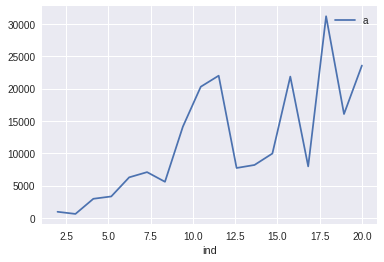

In [ ]:
change=pd.DataFrame(Index,columns=["a"])
change["ind"]=np.linspace(2,len(change)+2,len(change))
change.plot("ind",["a"])

In [ ]:
change["a"]

0       963.400434
1       634.941095
2      2972.537803
3      3333.920432
4      6282.915048
5      7089.587123
6      5599.006891
7     14114.552403
8     20281.281605
9     21988.743394
10     7730.591241
11     8195.409448
12     9964.952790
13    21848.004633
14     7976.942607
15    31169.623609
16    16066.517087
17    23556.302722
Name: a, dtype: float64

In [ ]:
change["a"].argmin()

1

In [ ]:
recomended=change["a"].argmin()+2
GMM_test= GaussianMixture(n_components=recomended, covariance_type="full",random_state=0).fit(X)
predy=GMM_test.predict(X)
recomended

3

In [ ]:
adjusted_mutual_info_score(Y, predy)

0.0

In [ ]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(Y, predy)

1.0

## With the merging methodology 

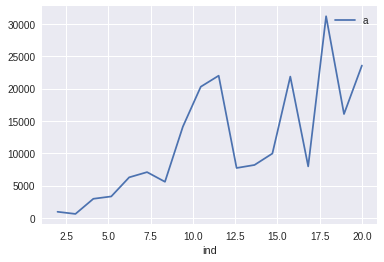

In [ ]:
from sklearn.model_selection import train_test_split

Y = data1["target"]
X = data1.drop(columns = "target")

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)$

X_train111=X.copy()
GM = GaussianMixture(n_components=20, covariance_type="full",random_state=5).fit(X_train111)
X_train111["pred"]=GM.predict(X_train111)
Means=GM.means_
covariances=GM.covariances_
weights=GM.weights_
y=X_train111["pred"]
index=merguncertain (X,y,Means,covariances,weights,X.shape[1])
index.reverse()
change["ind"]=np.linspace(2,len(change)+2,len(change))

change.plot("ind",["a"])

In [ ]:
change=pd.DataFrame(index,columns=["a"])
recomended=change.iloc[:-1]["a"].argmin()+2
GMM_test= GaussianMixture(n_components=recomended, covariance_type="full",random_state=0).fit(X)
predy=GMM_test.predict(X)
recomended

2

In [ ]:
change

,a
0,3.494191e+05
1,1.373653e+06
2,2.341393e+06
3,5.638124e+06
4,5.802399e+06
5,7.140823e+06
6,7.438358e+06
7,7.561835e+06
8,6.033558e+06
9,1.311477e+07


In [ ]:
adjusted_mutual_info_score(Y, predy)

1.9889863667914856e-15

In [ ]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(Y, predy)

1.0